## Imports

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
PREPROCESSED_DATA_PATH = "../../../data/preprocessed/"

## Read Data

In [3]:
train_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "train.parquet")

val_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "validation.parquet")
small_test_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "test.parquet")

test_df = pd.concat([val_df, small_test_df], axis=0)

## Split Data Into Training and Testing

In [4]:
TARGET = 'copiesSold'

X_train = train_df.drop(columns=TARGET)
y_train = train_df[TARGET]

X_test = test_df.drop(columns=TARGET)
y_test = test_df[TARGET]

In [5]:
pd.set_option('display.max_columns', None)
X_train.head()

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other
11655,0,0,0,-0.127185,1,0.0,2024,0.230306,-0.973118,-0.959158,-0.331901,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.422150,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
9303,0,0,0,-0.127185,1,0.0,2024,-0.060213,-0.998186,-1.631332,1.072290,0,0,0,0,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.430898,0.109341,0.140908,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
56618,0,0,0,-0.127185,1,0.0,2007,0.179767,-0.983709,-0.061180,-0.331901,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.575401,0.109341,0.301146,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
55579,1,0,0,0.105103,1,0.0,2019,-0.188227,0.982126,-1.631332,-0.331901,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.129008,0.703911,0.243282,-0.241008,7.064584,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
64439,1,0,0,-0.069113,1,0.0,2022,0.280231,-0.959933,-1.631332,1.180305,0,0,1,1,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-0.833418,-1.079798,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0


In [6]:
y_train.head()

11655    0
9303     0
56618    0
55579    1
64439    1
Name: copiesSold, dtype: int64

## Define Models and Hyperparameter Grids

In [7]:
models = {
    'LogisticRegression': {
        'get_model': lambda param: LogisticRegression(C=param, max_iter=1000, solver='liblinear'),
        'param_name': 'C',
        'param_values': [1]
    },
    'LinearSVC': {
        'get_model': lambda param: LinearSVC(C=param, max_iter=10000),
        'param_name': 'C',
        'param_values': [0.1, 1, 10]
    },
    'XGBoost': {
        'get_model': lambda param: XGBClassifier(learning_rate=param, eval_metric='logloss', n_jobs=-1),
        'param_name': 'learning_rate',
        'param_values': [0.1, 0.2, 0.3]
    }
}

## Feature Selection and Hyperparameter Tuning


Running RFECV for LogisticRegression...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


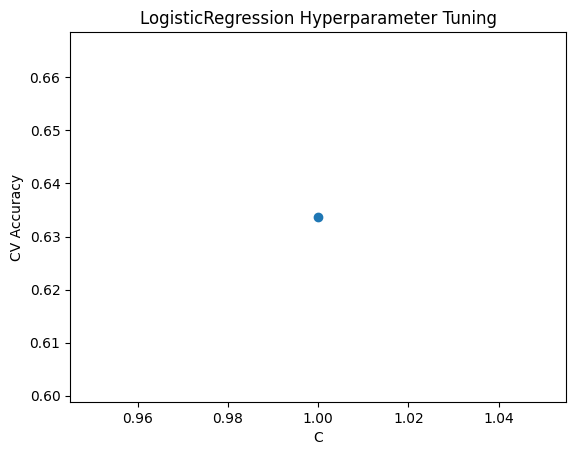


Running RFECV for LinearSVC...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 featur

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished



Running RFECV for LinearSVC...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 42 featur

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished



Running RFECV for LinearSVC...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 featur

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


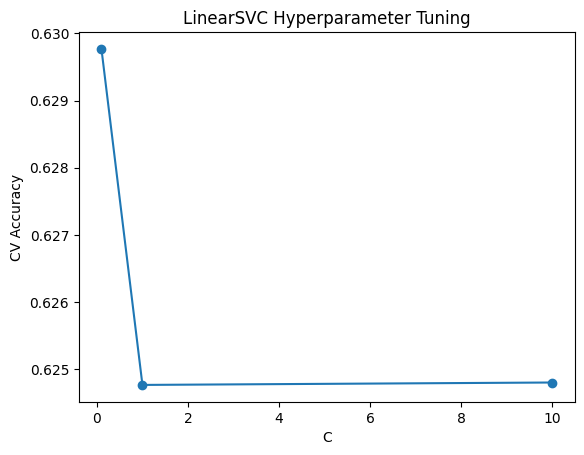


Running RFECV for XGBoost...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished



Running RFECV for XGBoost...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished



Running RFECV for XGBoost...
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


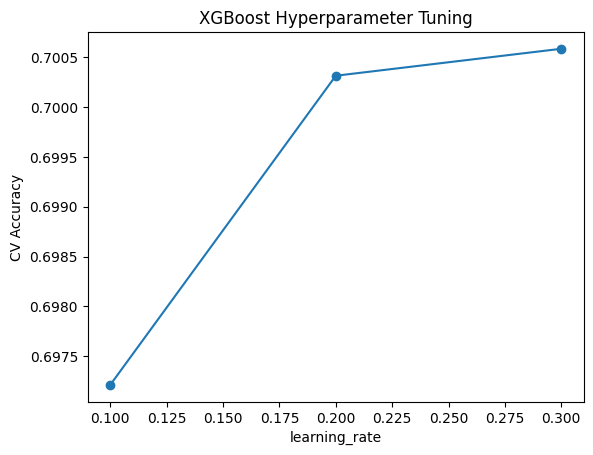

In [8]:
best_params = {}
best_selectors = {}

for model_name, info in models.items():
    scores = []
    for val in info['param_values']:
        model = info['get_model'](val)
        # Feature Selection, RFECV automatically finds the best number of features
        print(f"\nRunning RFECV for {model_name}...")
        selector = RFECV(estimator=model, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        X_sel = selector.fit_transform(X_train, y_train)
        # Evaluate performance on selected features with the current hyperparameter
        print(f"\nRunning CV for {model_name}...")
        cv_scores = cross_val_score(model, X_sel, y_train, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        scores.append(np.mean(cv_scores))

    # Plot hyperparameter tuning curve
    plt.figure()
    plt.plot(info['param_values'], scores, marker='o')
    plt.xlabel(info['param_name'])
    plt.ylabel('CV Accuracy')
    plt.title(f'{model_name} Hyperparameter Tuning')
    plt.show()

    # Record best hyperparameter and corresponding RFECV selector (which contains the best features selected for this model)
    best_index = int(np.argmax(scores))
    best_param = info['param_values'][best_index]
    best_params[model_name] = best_param
    best_model = info['get_model'](best_param)
    best_selectors[model_name] = RFECV(estimator=best_model, cv=3, scoring='accuracy')
    best_selectors[model_name].fit(X_train, y_train)

## Training and Testing

['LogisticRegression', 'LinearSVC', 'XGBoost']
[0.63, 0.626, 0.704]


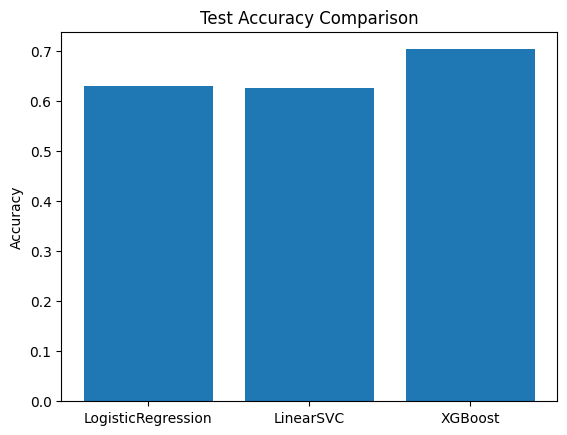

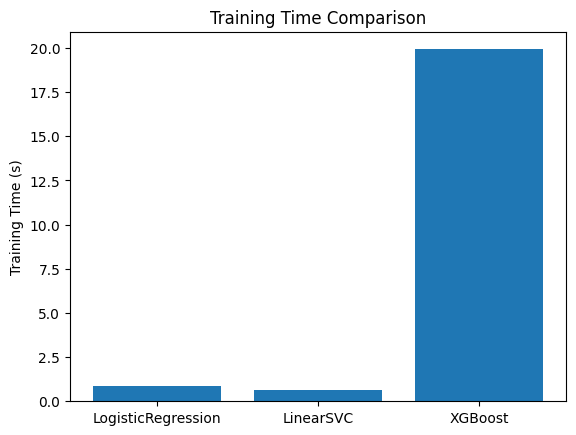

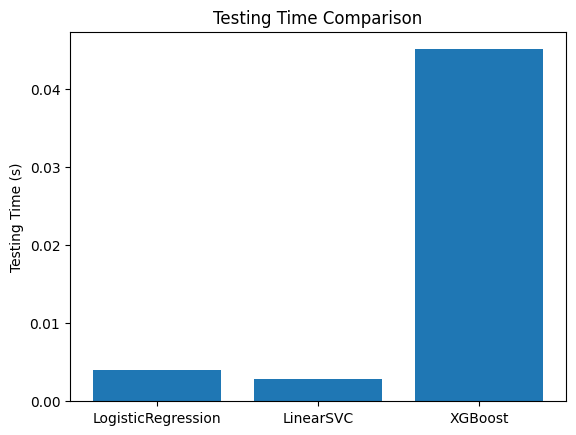

In [15]:
# Train final models and collect metrics
train_times = {}
test_times = {}
accuracies = {}

for model_name, info in models.items():
    selector = best_selectors[model_name]
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    model = info['get_model'](best_params[model_name])

    # Training
    start = time.time()
    model.fit(X_train_sel, y_train)
    train_times[model_name] = time.time() - start

    # Testing
    start = time.time()
    y_pred = model.predict(X_test_sel)
    test_times[model_name] = time.time() - start

    # Accuracy
    accuracies[model_name] = accuracy_score(y_test, y_pred)

# Bar plot: Test Accuracy
print(list(accuracies.keys()))
print(list(round(accuracy, 3) for accuracy in accuracies.values()))
plt.figure()
plt.bar(list(accuracies.keys()), list(accuracies.values()))
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

# Bar plot: Training Time
plt.figure()
plt.bar(list(train_times.keys()), list(train_times.values()))
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison')
plt.show()

# Bar plot: Testing Time
plt.figure()
plt.bar(list(test_times.keys()), list(test_times.values()))
plt.ylabel('Testing Time (s)')
plt.title('Testing Time Comparison')
plt.show()